In [7]:
from processed_data import GreyUTKFace
from models.GreyUTKFaceVAE import Model as VAE
import matplotlib.pyplot as plt

In [5]:
test_dataset = GreyUTKFace.Dataset(train=False, sample=False)

In [11]:
a_face, an_age = test_dataset[0]

Text(0.5,1,'26')

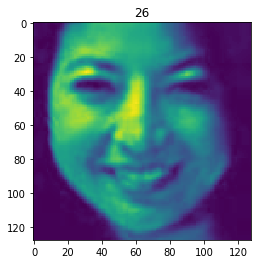

In [14]:
plt.imshow(a_face.view(128, 128).numpy())
plt.title(an_age)

In [16]:
target_age = an_age + 10